## Analysis of the link between mobility change and democracy index

Load democracy indexes from Our World in Data (https://ourworldindata.org/democracy) :

"Based on the expert assessments and index by V-Dem. It combines information on voting rights, the freedom and fairness of elections,freedoms of association and expression, civil liberties, and executive constraints. It ranges from 0 to 1 (most democratic)"

In [ ]:
# Load the democracy index data
democracy_index = pd.read_csv('data/liberal_democracy_index.csv')

#Extracting the 2020 data
democracy_index_2020 = democracy_index[democracy_index['Year']==2020]

#Drop the useless columns and rename some columns
democracy_index_2020.drop(['Year', 'libdem_vdem_low_owid', 'libdem_vdem_high_owid'], axis=1, inplace=True)
democracy_index_2020.rename(columns={"libdem_vdem_owid": "dem_index"}, inplace=True)

#Drop the data with nan values
democracy_index_2020.dropna(inplace=True)

Enrich the Google and Apple mobility reports with this data by merging the datasets

In [ ]:
#Join with google mobility report
df_google_mob_dem_index = df_google_mobility.merge(democracy_index_2020, left_on='country_region', right_on='Entity')

#Join with Apple mobility report
#Before, change the name of the country Republic of Korea as South Korea so that the merge will work for this country
#df_apple_mobility.loc[df_apple_mobility.region=='Republic of Korea']['region'] = 'South Korea'
df_apple_mobility.replace('Republic of Korea', 'South Korea', inplace=True)
df_apple_mob_dem_index = df_apple_mobility.merge(democracy_index_2020, left_on='region', right_on='Entity')

Compute the mobility drop in the Apple dataset

In [ ]:
#Add columns with the 2 highest and the two lowest weeks in terms of driving/walking
df_apple_mob_dem_index['highest_period_value'] = np.nan
df_apple_mob_dem_index['lowest_period_value'] = np.nan

#Number of days of the period on which the mean is computed
nb_days_period = 14

#Iterate over all countries
for i in range (df_apple_mob_dem_index.shape[0]) :
    # Extract data about the current country
    current_row = df_apple_mob_dem_index.iloc[i]
    country = current_row['region']
    #Keep only the numerical information
    current_row.drop(['geo_type', 'region', 'transportation_type', 'Entity', 'Code', 'dem_index'], inplace=True)
    #Compute the min and max means over 2 floating weeks
    highest_period_value = current_row.rolling(nb_days_period).mean().max()
    lowest_period_value = current_row.rolling(nb_days_period).mean().min()
    #Add these values to the dataset
    df_apple_mob_dem_index['highest_period_value'].iloc[i] = highest_period_value
    df_apple_mob_dem_index['lowest_period_value'].iloc[i] = lowest_period_value

#Considering that the highest mobility value corresponds to the pre lockdown period and the lowest mobility
#corresponds to the lockdown period, we can compute the decrease in the mobility in percents
df_apple_mob_dem_index['mob_variation'] = (df_apple_mob_dem_index['lowest_period_value'] - df_apple_mob_dem_index['highest_period_value']) / df_apple_mob_dem_index['highest_period_value']

Plot the mobility change as a function of the democracy index. Display also the GDP per capita of the different countries

In [ ]:
#Loading the data about GDP per capita
df_gdp = pd.read_csv('data/gdp-per-capita-worldbank.csv')

#Keep only the 2020 values
df_gdp = df_gdp[df_gdp.Year == 2020]

#Rename the GDP column
df_gdp.rename (columns = {'GDP per capita, PPP (constant 2017 international $)' : 'gdp_per_capita'}, inplace=True)

#Drop country code and year columns
df_gdp.drop(['Code', 'Year'], axis=1, inplace=True)

#Add the log of the GDP to the dataframe
df_gdp['log_gdp_per_capita'] = df_gdp['gdp_per_capita'].apply(np.log10)

df_gdp.head()

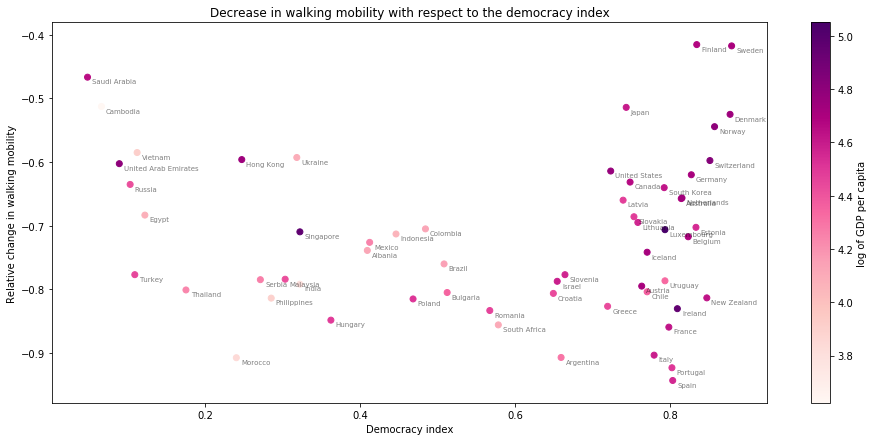

In [ ]:
# Plotting the mobility change vs democracy index with visualization of the GDP per capita

#Keep only the mobility variations for walking
df_plot = df_apple_mob_dem_index[df_apple_mob_dem_index['transportation_type'] == 'walking']
df_plot = df_plot[['region', 'dem_index', 'mob_variation']].merge(df_gdp, left_on='region', right_on='Entity')


#Plotting the name of the countries
plt.figure(figsize=(16, 7))
for i in range (df_plot.shape[0]) :
    plt.text(x=df_plot.iloc[i]['dem_index']+.006, y=df_plot.iloc[i]['mob_variation']-.01, s=df_plot.iloc[i]['region'], fontdict=dict(color='black',size=7), alpha=.5)

#Scatter plot with the mob_change as a function of the democracy index
plt.scatter(df_plot['dem_index'], df_plot['mob_variation'], c=df_plot['log_gdp_per_capita'], cmap='RdPu')

#Adding titles and showing
plt.title('Decrease in walking mobility with respect to the democracy index')
plt.xlabel('Democracy index')
plt.ylabel('Relative change in walking mobility')
plt.colorbar(label='log of GDP per capita')
plt.savefig('images/decrease_walking_vs_dem_index.png')

plt.show()

Same thing but with a linear regression on the countries with a democracy index < 0.7

                            OLS Regression Results                            
Dep. Variable:          mob_variation   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     17.51
Date:                Fri, 23 Dec 2022   Prob (F-statistic):           0.000256
Time:                        13:01:25   Log-Likelihood:                 31.308
No. Observations:                  30   AIC:                            -58.62
Df Residuals:                      28   BIC:                            -55.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6149      0.033    -18.391      0.0

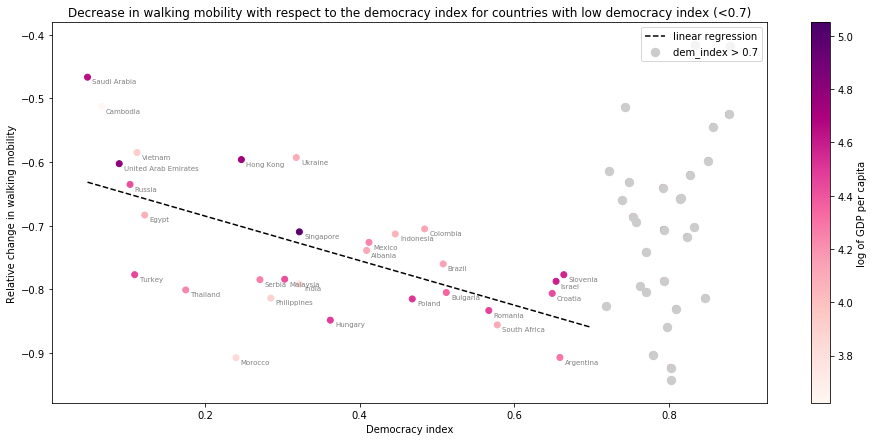

In [ ]:
#Do the same but separating countries which have a dem index lower than .7 and countries > .7

#Keep only the mobility variations for walking
df_plot = df_apple_mob_dem_index[df_apple_mob_dem_index['transportation_type'] == 'walking']
df_plot = df_plot[['region', 'dem_index', 'mob_variation']].merge(df_gdp, left_on='region', right_on='Entity')
df_plot_democratic_countries = df_apple_mob_dem_index[(df_apple_mob_dem_index['transportation_type'] == 'walking') & (df_apple_mob_dem_index['dem_index'] > .7)]
df_plot_democratic_countries = df_plot_democratic_countries[['region', 'dem_index', 'mob_variation']].merge(df_gdp, left_on='region', right_on='Entity')
df_plot_undemocratic_countries = df_apple_mob_dem_index[(df_apple_mob_dem_index['transportation_type'] == 'walking') & (df_apple_mob_dem_index['dem_index'] <= .7)]
df_plot_undemocratic_countries = df_plot_undemocratic_countries[['region', 'dem_index', 'mob_variation']].merge(df_gdp, left_on='region', right_on='Entity')


#Plotting the name of the countries
plt.figure(figsize=(16, 7))
for i in range (df_plot_undemocratic_countries.shape[0]) :
    plt.text(x=df_plot_undemocratic_countries.iloc[i]['dem_index']+.006, y=df_plot_undemocratic_countries.iloc[i]['mob_variation']-.01, s=df_plot_undemocratic_countries.iloc[i]['region'], fontdict=dict(color='black',size=7), alpha=.5)

#Scatter plot with the mob_change as a function of the democracy index
plt.scatter(df_plot['dem_index'], df_plot['mob_variation'], c=df_plot['log_gdp_per_capita'], cmap='RdPu', label='_nolegend_')
plt.colorbar(label='log of GDP per capita')
plt.scatter(df_plot_democratic_countries['dem_index'], df_plot_democratic_countries['mob_variation'], color=[.8, .8, .8], s=70, label='dem_index > 0.7')

#Run linear regression and get coefficients
mod = smf.ols(formula='mob_variation ~ dem_index', data=df_plot_undemocratic_countries)
res = mod.fit()
print (res.summary())
coefficients = res.params.values

#Plot the corresponding line
x_line = np.array([df_plot['dem_index'].min(), 0.7])
y_line = coefficients[0] + coefficients[1] * x_line
plt.plot(x_line, y_line, 'k--', label='linear regression')


#Adding titles and showing
plt.title('Decrease in walking mobility with respect to the democracy index for countries with low democracy index (<0.7)')
plt.xlabel('Democracy index')
plt.ylabel('Relative change in walking mobility')
plt.legend(loc='upper right')
plt.savefig('images/decrease_walking_vs_dem_index_with_regression.png')

plt.show()

Study the link between GDP per capita and democracy index

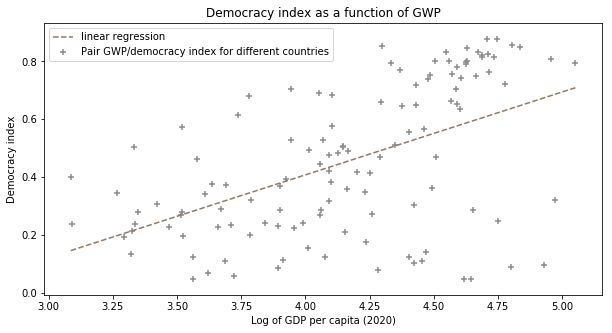

                            OLS Regression Results                            
Dep. Variable:              dem_index   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     44.99
Date:                Fri, 23 Dec 2022   Prob (F-statistic):           6.73e-10
Time:                        13:01:22   Log-Likelihood:                 12.542
No. Observations:                 123   AIC:                            -21.08
Df Residuals:                     121   BIC:                            -15.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.7401      0

In [ ]:
#Now plot the results of the linear regression on the scatter plot

#Getting sns colors
colors = sns.color_palette('deep')

#Scatter plot
plt.figure (figsize=(10, 5))
plt.scatter (df_dem_index_gdp['log_gdp_per_capita'],df_dem_index_gdp['dem_index'], color=colors[7], marker='+', label='Pair GWP/democracy index for different countries')

#Linear regression
x = np.linspace (df_dem_index_gdp['log_gdp_per_capita'].min(), df_dem_index_gdp['log_gdp_per_capita'].max(), 10)
y = coefficients[1]*x + coefficients[0]
plt.plot(x, y, color=colors[5], linestyle='--', label='linear regression')

#Add titles and legend
plt.title("Democracy index as a function of GWP")
plt.xlabel("Log of GDP per capita (2020)")
plt.ylabel('Democracy index')
plt.legend()
plt.savefig('images/gdp_dem_index.png')

plt.show()

print (res.summary())